In [1]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.transforms import transforms
from PIL import Image
import torchvision.transforms.functional as tvf
import torchvision.utils as tvu
from torch import Tensor
import torchvision.transforms as tvt
import os
from tqdm import tqdm
import random

## Utils

In [2]:
# 将一个PIL图像Resize后并转换为Tensor
def resize2tensor(image: Image, size: int) -> Tensor:
    transform = tvt.Compose([
        tvt.Resize(size, interpolation=tvf.InterpolationMode.BICUBIC),
        tvt.ToTensor()
    ])
    return transform(image)


def show_images_tensor(images_per_row: int, images_tensor: Tensor, size=4):
    """
    展示图片
    :param images_per_row: 每行展示的图片数量
    :param images_tensor: B*W*H*C
    :return:
    """
    # Create a grid of images using make_grid
    grid = tvu.make_grid(images_tensor, nrow=images_per_row, padding=2, normalize=True)

    # Convert the grid tensor to a numpy array and transpose the dimensions for displaying
    grid_np = grid.numpy().transpose((1, 2, 0))

    # Display the grid of images using matplotlib
    plt.figure(figsize=(size, size))
    plt.imshow(np.clip(grid_np, 0, 1))
    plt.axis("off")
    plt.show()

## Dataset

In [3]:
class ImageDataset(Dataset):
    def __init__(self, img_size, img_folder, min_size, img_nums):
        super().__init__()
        self.all_img_names = sorted(os.listdir(img_folder))
        self.img_folder = img_folder
        
        self.img_names = []
        # 将低像素的图片过滤掉
        for img_name in self.all_img_names:
            if len(self.img_names) >= img_nums:
                break
            width, height = Image.open(os.path.join(self.img_folder, img_name)).size
            if width >= min_size and height >= min_size:
                self.img_names.append(img_name)

        self.input_transform = transforms.Compose([
            transforms.Resize((img_size, img_size),
                              interpolation=tvf.InterpolationMode.BICUBIC),
            transforms.ToTensor()
        ])

    def __getitem__(self, item):
        img_name = self.all_img_names[item]
        img_path = os.path.join(self.img_folder, img_name)
        img = Image.open(img_path).convert('RGB')

        input_img = self.input_transform(img)

        return input_img

    def __len__(self):
        return len(self.img_names)

### Set parameters and load data

In [4]:
img_size = 32
img_folder = 'D:/Materials/dataset/train/Anime face/images'
img_size_min = 32
img_nums = 2000

In [5]:
training_dataset = ImageDataset(img_size=img_size, img_folder=img_folder, min_size=img_size_min, img_nums=img_nums)
training_dataloader = DataLoader(training_dataset, batch_size=16, num_workers=0, drop_last=True)

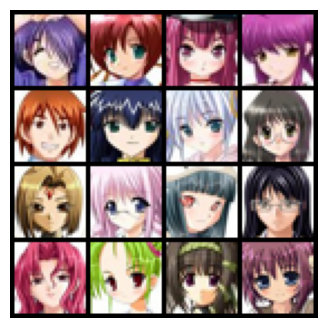

In [6]:
for input_images in training_dataloader:
    show_images_tensor(4, input_images)
    break

In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

n_steps = 500
# 注意下标从0开始
beta = torch.linspace(0.0001, 0.01, n_steps).to(device)
alpha = 1 - beta
alpha_bar = torch.cumprod(alpha, dim=0)
sigma = torch.sqrt(beta)

### Get $x_t$
$$\boldsymbol{x_t}=\sqrt{\bar{\alpha}_t}\boldsymbol{x_0}+\sqrt{1-\bar{\alpha}_t}\boldsymbol{\epsilon}$$
$$\boldsymbol{\epsilon}\sim N(0,I)$$

In [8]:
def get_xt_given_x0_and_t(x0, t):
    eps = torch.randn(x0.shape).to(device)
    xt = torch.sqrt(alpha_bar[t-1]) * x0 + torch.sqrt(1 - alpha_bar[t-1]) * eps
    return xt, eps

### Select a $x_0$ and show $x_t$

In [9]:
def select_x0_and_show_xt():
    # select an image
    for input_images in training_dataloader:
        x0 = input_images[0].to(device)
        break
    
    xts = []
    # progressively add noise (but actually directly computed)
    for i in range(1, n_steps+1):
        xt, _ = get_xt_given_x0_and_t(x0, i)
        xt = xt.cpu()
        xts.append(xt)
        
    xts = torch.stack(xts)
    
    show_images_tensor(5, xts, size=15)

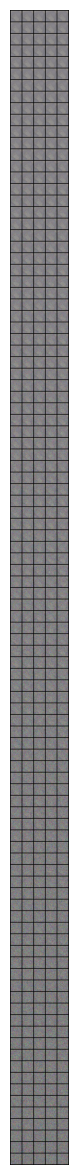

In [10]:
select_x0_and_show_xt()

### Sampling with trained model
$$\boldsymbol{x}_{t-1}=\frac{1}{\sqrt{\bar{\alpha}}}(\boldsymbol{x}_t-\frac{1-\alpha_t}{\sqrt{1-\bar{\alpha}_t}}*\boldsymbol{\epsilon}_\theta(\boldsymbol{x}_t, t))+\sigma_t*\boldsymbol{z}$$

In [11]:
def sampling(xt, t, model):
    sampling_results = []
    # 计算x_{t-1},...,x0
    for i in range(t, 0, -1):
        z = torch.randn(*xt.shape).to(device)

        eps_theta = model(xt, i)
        xt = 1. / torch.sqrt(alpha_bar[i-1]) * (xt - (1-alpha[i-1]) / torch.sqrt(1 - alpha_bar[i-1]) * eps_theta) + sigma[i-1] * z
        # 存放结果
        sampling_results.append(xt.view(3, img_size, img_size))

    sampling_results = torch.stack(sampling_results)

    return sampling_results

In [12]:
class EpsilonPredictor(nn.Module):
    def __init__(self):
        super(EpsilonPredictor, self).__init__()
        self.layers = nn.Sequential(nn.Conv2d(3, 16, 3, 1, 1), nn.ReLU(), nn.Conv2d(16, 8, 3, 1, 1), nn.ReLU(), nn.Conv2d(8, 3, 3, 1, 1))

    def forward(self, x, t):
        res = self.layers(x+t)
        return res

### Train the model
$$\nabla_{\theta}\Vert \boldsymbol{\epsilon}-\boldsymbol{\epsilon}_{\theta}(x_t, t)\Vert^2$$

In [13]:
def train():
    model = EpsilonPredictor().to(device)

    criterion = nn.MSELoss()

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    epoch_num = 100
    for i in tqdm(range(epoch_num), desc='Training'):
        for input_images in training_dataloader:
            input_images = input_images.to(device)

            t = random.randint(1, n_steps)
            t_for_model = torch.zeros_like(input_images).to(device) + t

            xt, eps = get_xt_given_x0_and_t(input_images, t)

            eps_theta = model(xt, t_for_model)

            loss = criterion(eps_theta, eps)
            loss.backward()

            optimizer.step()
            optimizer.zero_grad()

    noise = torch.randn(1, 3, img_size, img_size).to(device)
    sampling_results = sampling(noise, n_steps, model)

    return sampling_results

## Run

In [14]:
sampling_results = train()

Training: 100%|██████████| 100/100 [01:56<00:00,  1.16s/it]


In [15]:
sampling_results.shape

torch.Size([500, 3, 32, 32])

In [16]:
sampling_results = sampling_results.permute(0, 2, 3, 1)

In [17]:
sampling_results.shape

torch.Size([500, 32, 32, 3])

In [18]:
# 将 PyTorch tensor 转换为 numpy 数组
images = sampling_results.detach().cpu()

In [19]:
images[0]

tensor([[[ 0.0206, -0.3713, -3.5518],
         [-6.0064,  0.3889,  4.3475],
         [ 6.1914, -2.5942, -8.7088],
         ...,
         [ 0.4249,  4.2122, -3.9205],
         [ 0.8506, -2.6032,  3.5836],
         [-0.4958, -0.3836, -5.3924]],

        [[ 2.8810,  2.2869,  0.1149],
         [ 2.2190, -3.8546, -0.7370],
         [-4.6944, -4.2388,  0.9727],
         ...,
         [ 0.7861, -4.1358,  1.5993],
         [ 1.1925, -1.1193,  2.3140],
         [ 7.3675, -0.8143,  2.6123]],

        [[-1.5835,  1.8281, -2.6428],
         [ 2.8779,  0.4746, -0.6726],
         [ 1.8842, -5.3905,  1.4304],
         ...,
         [-1.2995, -0.3313,  1.4961],
         [-0.8029, -0.3655,  8.1495],
         [ 0.4890,  0.8603,  1.3496]],

        ...,

        [[ 2.7457,  3.7358, -1.3177],
         [ 2.9601,  1.8911, -0.8328],
         [-5.5646, -1.2361,  6.7704],
         ...,
         [ 5.1668, -3.2978, -1.0020],
         [-4.1791, -0.2474,  8.6441],
         [-0.5799, -3.5824, -3.3331]],

        [[

D:\Anaconda\lib\site-packages\matplotlib\cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


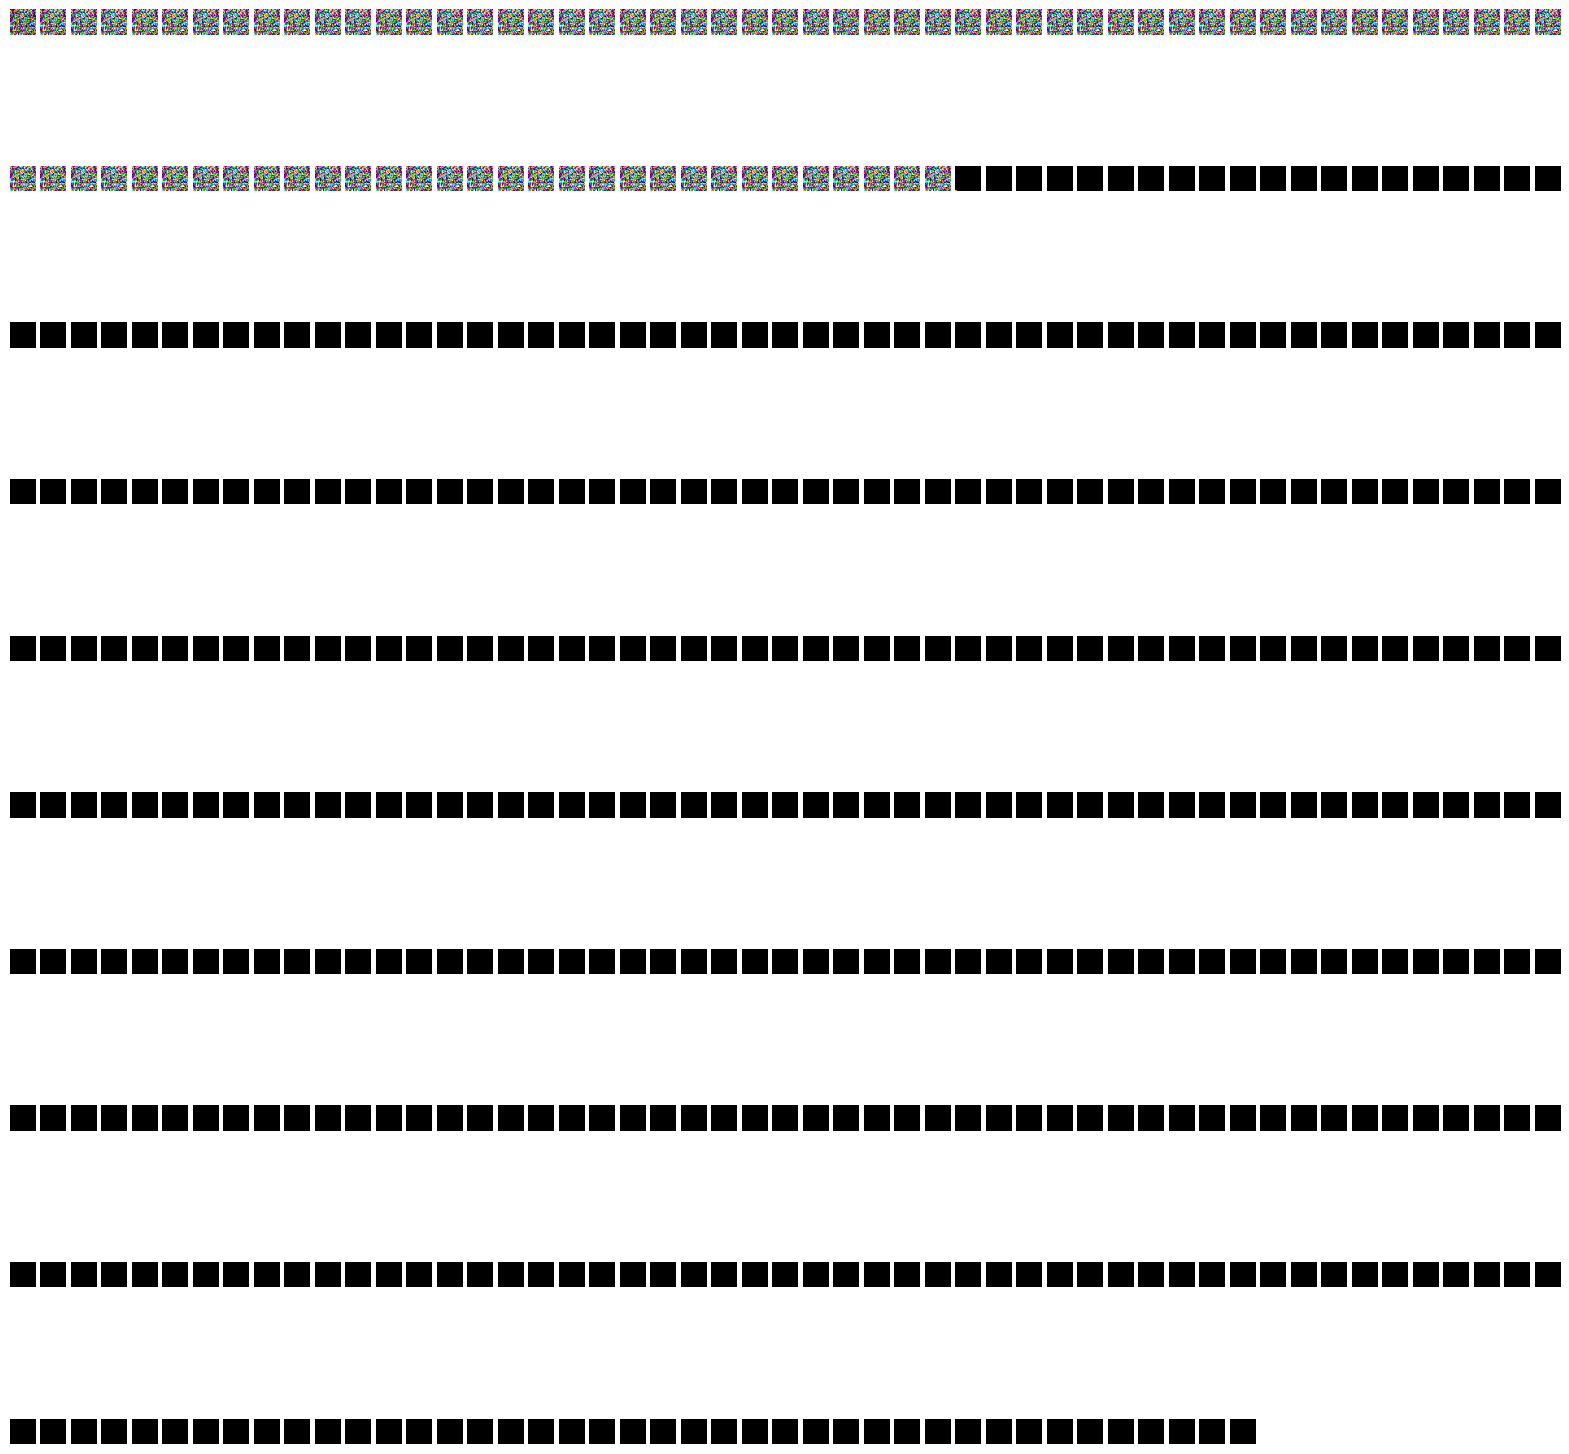

In [20]:
plt.figure(figsize=(20, 20))
for i in range(n_steps):
    plt.subplot(10, n_steps//10+1, i+1)
    plt.imshow(np.clip(images[i], 0, 1))
    plt.axis("off")
plt.show()